# Customer segmentation

## Porblem statment :

Given a dataset of products sales, we are going to explore and understand customer behaviors through EDA, RMF and clustring. 

## Prerequisites

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot

In [4]:
# read data
data = pd.read_excel("gdrive/MyDrive/Colab Notebooks/bdd.xlsx")
data.head()

,CLIENT_CATEGORIE,CLIENT_CODE,CLIENT_CPOSTAL,CLIENT_DPT,CLIENT_GEO,CLIENT_PAYS,ARTICLE_REF,ARTICLE_FAMILLE,ARTICLE_MARQUE,VENTE_DATE,VENTE_CANAL,VENTE_QTE,VENTE_MONTANT,VENTE_NUMEROPIECE,VENTE_NATURE,MARGE
0,PARTICULIER,277,24250,24,FRANCE,FRA,REMISE_INTERNET,Non renseigné,NC,2015-12-28,VENTE EN LIGNE,1.0,-47.42,702322,FACTURE,-47.4200
1,PARTICULIER,277,24250,24,FRANCE,FRA,231K589,Electricité,NC,2015-12-28,VENTE EN LIGNE,2.0,7.00,702322,FACTURE,4.5000
2,PARTICULIER,277,24250,24,FRANCE,FRA,COLE6368W1,Moteur,NORMA,2015-12-28,VENTE EN LIGNE,4.0,9.68,702322,FACTURE,5.4000
3,PARTICULIER,277,24250,24,FRANCE,FRA,231K894R,Electricité,NC,2015-12-28,VENTE EN LIGNE,3.0,9.99,702322,FACTURE,5.8608
4,PARTICULIER,277,24250,24,FRANCE,FRA,8RS0A803,Electricité,REDSPEC,2015-12-28,VENTE EN LIGNE,1.0,34.08,702322,FACTURE,12.2705


In [5]:
# date interval
print("min date : ", data["VENTE_DATE"].min(), "\nmax date : ", data["VENTE_DATE"].max())

min date :  2014-01-01 00:00:00 
max date :  2015-12-31 00:00:00


The dataset describes purchases (date\*customer\*product) from 2014-01-01 to 2015-12-31 of a distribution company B2B and B2C

## Data Quality and EDA

In this part, I'm going to explore the dataset to check its quality and understand each feature. 

### Duplicated data

In [6]:
# Cheque duplicated data
print('Duplicate entries: {}'.format(data.duplicated().sum()))

Duplicate entries: 1768


In [9]:
# Examples of duplicate data
data[data.duplicated(keep=False)].head()

,CLIENT_CATEGORIE,CLIENT_CODE,CLIENT_CPOSTAL,CLIENT_DPT,CLIENT_GEO,CLIENT_PAYS,ARTICLE_REF,ARTICLE_FAMILLE,ARTICLE_MARQUE,VENTE_DATE,VENTE_CANAL,VENTE_QTE,VENTE_MONTANT,VENTE_NUMEROPIECE,VENTE_NATURE,MARGE
388,PARTICULIER,204,39300,39,FRANCE,FRA,REMISE_PACK,Non renseigné,NC,2015-10-01,VENTE EN LIGNE,1.0,-7.80,679691,FACTURE,-7.80
389,PARTICULIER,204,39300,39,FRANCE,FRA,REMISE_PACK,Non renseigné,NC,2015-10-01,VENTE EN LIGNE,1.0,-7.80,679691,FACTURE,-7.80
1623,PARTICULIER,579,88550,88,FRANCE,FRA,REMISE_PACK,Non renseigné,NC,2014-01-15,VENTE EN LIGNE,1.0,-33.22,520500,FACTURE,-33.22
1624,PARTICULIER,579,88550,88,FRANCE,FRA,REMISE_PACK,Non renseigné,NC,2014-01-15,VENTE EN LIGNE,1.0,-33.22,520500,FACTURE,-33.22
1625,PARTICULIER,579,88550,88,FRANCE,FRA,607TO0112,Pilote,TURN ONE,2014-01-15,VENTE EN LIGNE,1.0,82.50,520500,FACTURE,46.50


One possible explanation of these duplicates is that the customer bought the same product several times at the same day without updating the quantity. Hopfully, we can see that the VENTE_NUMEROPIECE is the same for duplicated transactions, hence it's advisable to remove them from the dataset.

In [10]:
# Drop duplicates
data.drop_duplicates(inplace = True)

### Null values

In [11]:
# Explore the dataset
def explore(df): 
    """
    Compute type, null values, missing values ratio and unique values for each column
    """
    obs = df.shape[0]
    types = df.dtypes
    uniques = df.apply(lambda x: [x.unique()]).T
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ratio = (df.isnull().sum()/obs) * 100
    #negatif_ratio = np.round((data.select_dtypes(include=np.number).lt(0).sum()/data.shape[0]) * 100, 2)
    #msmm = df.describe().T[['mean', 'std', 'min', 'max']]
    
    cols = ['types', 'nulls', 'missing ration', 'uniques', 'distincts']
    expl = pd.concat([types, nulls, missing_ratio, uniques, distincts], axis = 1, sort=True)
    
    expl.columns = cols
    dtypes = expl.types.value_counts()
    return expl

details = explore(data)
display(details.sort_values(by='missing ration', ascending=False))

,types,nulls,missing ration,uniques,distincts
ARTICLE_MARQUE,object,836,0.204507,"[NC, NORMA, REDSPEC, HJS, STILO, GOODRIDGE, ST...",262
CLIENT_DPT,object,595,0.145552,"[24, 14, 5, 74, 38, 46, 76, 25, 82, 84, 62, 12...",231
ARTICLE_FAMILLE,object,5,0.001223,"[Non renseigné, Electricité, Moteur, Pilote, H...",25
CLIENT_CPOSTAL,object,2,0.000489,"[24250, 14340, 5130, 74500, 38450, 46400, 7664...",7684
ARTICLE_REF,object,0,0.000000,"[REMISE_INTERNET, 231K589, COLE6368W1, 231K894...",21822
CLIENT_CATEGORIE,object,0,0.000000,"[PARTICULIER, EQUIPE COURSE, INDUSTRIEL, GARAG...",12
CLIENT_CODE,int64,0,0.000000,"[277, 278, 171, 279, 280, 172, 281, 282, 283, ...",1424
CLIENT_GEO,object,0,0.000000,"[FRANCE, WORLD]",2
CLIENT_PAYS,object,0,0.000000,"[FRA, GOU, REU, MOM, CHE, GBR, BEL, ESP, COR, ...",82
MARGE,float64,0,0.000000,"[-47.42, 4.5, 5.4, 5.8608, 12.2705, 16.28, 23....",108022


There are missing values in the columns *ARTICLE_MARQUE*, *CLIENT_DPT*, *ARTICLE_FAMILLE*	and *CLIENT_CPOSTAL*. Since the ration of missing values represent a minority (does not surpass 0.3%), we will drop them from the dataset.  

The value "non renseigné" is presented in the *ARTICLE_FAMILLE* column 18674 times and it is equivilant to Null value. We will let this values for now.

In [12]:
# drop null values
data = data.dropna(subset=["ARTICLE_MARQUE", "CLIENT_DPT", "ARTICLE_FAMILLE", "CLIENT_CPOSTAL"])
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407367 entries, 0 to 410555
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   CLIENT_CATEGORIE   407367 non-null  object        
 1   CLIENT_CODE        407367 non-null  int64         
 2   CLIENT_CPOSTAL     407367 non-null  object        
 3   CLIENT_DPT         407367 non-null  object        
 4   CLIENT_GEO         407367 non-null  object        
 5   CLIENT_PAYS        407367 non-null  object        
 6   ARTICLE_REF        407367 non-null  object        
 7   ARTICLE_FAMILLE    407367 non-null  object        
 8   ARTICLE_MARQUE     407367 non-null  object        
 9   VENTE_DATE         407367 non-null  datetime64[ns]
 10  VENTE_CANAL        407367 non-null  object        
 11  VENTE_QTE          407367 non-null  float64       
 12  VENTE_MONTANT      407367 non-null  float64       
 13  VENTE_NUMEROPIECE  407367 non-null  int64   

### EDA about CLIENT_CODE and CLIENT_CATEGORIE

In [13]:
# find relationships between features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import plotly.express as px


#sns.pairplot(data, kind="scatter")
#plt.show()

In [14]:
def plot_pie(df, keys, title, min):
  """
  Plot pie chart
  """
  temp_df = pd.DataFrame()
  df = df.sort_index()
  #id_dist = data['CLIENT_CODE'].value_counts().sort_index()
  print("There are ", len(df), " unique ", keys," in this dataset.")
  temp_df[keys] = list(df.keys())
  temp_df['Frequence'] = list(df)
  temp_df[keys] = temp_df[keys].astype(str)
  temp_df.loc[temp_df['Frequence'] < min, keys] = 'Others'
  fig = px.pie(temp_df, values='Frequence', names=keys, title=title,
               color_discrete_sequence = px.colors.sequential.Aggrnyl)
  fig['data'][0].update({
                      'textinfo' : 'label+percent',
                      })
  fig.show()

# distribution of the CLIENT_CODE column
plot_pie(data['CLIENT_CODE'].value_counts(), 'CLIENT_CODE', 'Distribution of CLIENT_CODE', 150)
 
# distribution of CLIENT_CATEGORIE by VENTE_QTE
plot_pie(data.groupby(['CLIENT_CATEGORIE'])['VENTE_QTE'].sum(), 'CLIENT_CATEGORIE', 'Distribution of CLIENT_CATEGORIE by VENTE_QTE', 3000)

# distribution of MARQUE by VENTE_QTE
plot_pie(data.groupby(['ARTICLE_MARQUE'])['VENTE_QTE'].sum(), 'ARTICLE_MARQUE', 'Distribution of ARTICLE_MARQUE by VENTE_QTE', 10000)

There are  1423  unique  CLIENT_CODE  in this dataset.


There are  12  unique  CLIENT_CATEGORIE  in this dataset.


There are  261  unique  ARTICLE_MARQUE  in this dataset.


The id 0 represents 92.5% of all transactions, 38 represents 3.7% and all other ids represent only 4%. There is a huge unbalance.  
Individuals represent 59% of all transactions, GARAGE and DETAILLANT represent respectively 17.5% and 15%.  

Let's see if unique CLIENT_CODE represent unique CLIENT_CATEGORY.

In [15]:
# Check the category of CLIENT_CODE "0" and "38"
plot_pie(data[(data["CLIENT_CODE"]==0)]["CLIENT_CATEGORIE"].value_counts(), 'CLIENT_CATEGORIE', "Categories of CLIENT_CODE 0", 1500)
plot_pie(data[(data["CLIENT_CODE"]==38)]["CLIENT_CATEGORIE"].value_counts(), 'CLIENT_CATEGORIE', "Categories of CLIENT_CODE 38", 500)

There are  12  unique  CLIENT_CATEGORIE  in this dataset.


There are  10  unique  CLIENT_CATEGORIE  in this dataset.


The CLIENT_CODE = 0 represent different CLIENT_CATEGORY. Since one client can't represent Particulier, Indistriel, Ecole... at the same time, and can't be in multiple countries (unless it refers to a company), I suppose that the CLIENT_CODE = 0 represent unknown customers. It explains the unbalanced distribution of CLIENT_CODE column.   
  
Let's do the same thing for other CLIENT_CODEs

In [16]:
# cheque the country and category of client_code = 38 in a specific date
from datetime import datetime
print("Nb of countries of CLIENT_CODE=0 at 2015-06-02 : ", 
      data[(data["CLIENT_CODE"]==0)&(data["VENTE_DATE"]==\
                                      datetime.strptime('2015-06-02', '%Y-%m-%d'))]["CLIENT_PAYS"].value_counts().count()
      )
print("Nb of countries of CLIENT_CODE=38 at 2015-06-02 : ", 
      data[(data["CLIENT_CODE"]==38)&(data["VENTE_DATE"]==\
                                      datetime.strptime('2015-06-02', '%Y-%m-%d'))]["CLIENT_PAYS"].value_counts().count()
      )

Nb of countries of CLIENT_CODE=0 at 2015-06-02 :  14
Nb of countries of CLIENT_CODE=38 at 2015-06-02 :  2


As we can see, there are multiple CLIENT_CODE that represent different categories and countries at the same day (0, 38, 1467..).  
There are two possible cases, either the CLIENT_CODE does not represent unique customers, or the quality of data is not good and needs to be reviewed with the help of the Marketing team. 

Based on these possibilities, different approaches could be done :

1. We suppose that CLIENT_CODE column represent a subset of customers that shares some caracteristiques (0 : unknown customers for example), and segment customers based on it (we can also segment customers on the combination of CLIENT_CODE and CLIENT_CATEGORIE since it would represent more unique customers).
2. We suppose that the CLIENT_CODE is not representative and we only segment customers based on CLIENT_CATEGORIE. This could help us understand more each CATEGORIE.  

Let's explore the dataset further.

### EDA about VENTE_MONTANT, VENTE_QTE and MARGE

In [5]:
print(data[data["VENTE_QTE"]<0].shape[0]/data.shape[0])
print(data[data["VENTE_MONTANT"]<0].shape[0]/data.shape[0])
print(data[(data["VENTE_MONTANT"]<0)&(data["VENTE_QTE"]<0)].shape[0]/data.shape[0])

0.04836124669959762
0.08451465817087073
0.04521185903993609


#### Cancelations :

In [17]:
# describe sales data
data.drop(['CLIENT_CODE','VENTE_NUMEROPIECE'], axis = 1).describe()

,VENTE_QTE,VENTE_MONTANT,MARGE
count,407367.000000,407367.000000,407367.000000
mean,1.915699,73.676079,24.312822
std,8.199799,279.759971,89.479868
min,-499.000000,-29520.000000,-9709.990000
25%,1.000000,12.500000,4.438000
50%,1.000000,33.290000,12.775000
75%,2.000000,75.000000,29.160000
max,2000.000000,29520.000000,15000.000000


We can see that there are negative values in all 3 columns. Moreover, the minimum value of SALE_AMOUNT corresponds to its opposite maximum value. This could be interpreted as a cancelation.  

Let's check the real reason behind these negative values

In [18]:
# VENTE_NATURE column values
data['VENTE_NATURE'].value_counts()

FACTURE    387693
AVOIR       19674
Name: VENTE_NATURE, dtype: int64

This column represent the nature of each transaction (vente). After some research, I found out that invoice of type AVOIR is a commercial document issued by the seller to cancel an invoice or to refund a purchase (refund or equivalent value).  

So AVOIR means a canceled transaction. 

In [19]:
# Check the relationship between this type of invoice and quantity with negative values :
print(round(data[(data['VENTE_QTE']<0)&(data['VENTE_NATURE']=="AVOIR")].shape[0]/data[data['VENTE_NATURE']=="AVOIR"].shape[0]*100,3),
      "% of transactions with negative quantities are explained by cancelations.")
print(round(data[(data['VENTE_QTE']<0)&(data['VENTE_MONTANT']<0)&(data['VENTE_NATURE']=="AVOIR")].shape[0]/data[data['VENTE_NATURE']=="AVOIR"].shape[0]*100,3),
      "% of transactions with negative quantities and negative prices are explained by cancelations.")
print(round(data[(data['VENTE_QTE']<0)&(data['VENTE_MONTANT']>=0)&(data['VENTE_NATURE']=="AVOIR")].shape[0]/data[data['VENTE_NATURE']=="AVOIR"].shape[0]*100,3),
      "% of transactions with negative quantities and positive prices are explained by cancelations.")

99.883 % of transactions with negative quantities are explained by cancelations.
93.377 % of transactions with negative quantities and negative prices are explained by cancelations.
6.506 % of transactions with negative quantities and positive prices are explained by cancelations.


* 99.8% of negative quantities are explained by cancelations, which could mean that the canceled the purchase and returned the product. 
* 93.3% of negative quantities and negative prices are explained by cancelations, which could mean that the customer returned the product and got a refund. 
* 6.5% could mean that the customer exchanged the product with an equivalent good.



Let's see the category of customer that cancel the transactions.

In [20]:
plot_pie(data[(data['VENTE_QTE']<0)&(data['VENTE_NATURE']=="AVOIR")]["CLIENT_CATEGORIE"].value_counts(),
         keys='CLIENT_CATEGORIE', title="Categories of clients that perform cancelations.", min=500)

There are  11  unique  CLIENT_CATEGORIE  in this dataset.


We can say that all categories cancel their transactions with the same initial sales distribution.

In [21]:
plot_pie((-data[(data['VENTE_QTE']<0)&(data['VENTE_NATURE']=="AVOIR")].groupby(["ARTICLE_MARQUE"])["VENTE_QTE"].sum()),
         keys='ARTICLE_MARQUE', title="Marque of products that get calceled.", min=500)

There are  198  unique  ARTICLE_MARQUE  in this dataset.


Nothing to say, NC product is the most canceled product because it is the most solde one.  

Let's see the most valuable MARQUE (biggest sum of MARGE).

Let's check if canceled transactions have counterpart in the dataset or not. 

In [22]:
# Constucting a basket for later use
# Uncomment this line if you want to use CLIENT_CODE+CLIENT_CAREGORIE as the new id.
#data['CODE_CAT'] = [str(c)+str(i) for c,i in zip(data['CLIENT_CODE'], data['CLIENT_CATEGORIE'])]
# Add the Invoice type to the Invoice column (VENTE_NUMEROPIECE)
data['VENTE_NUMEROPIECE'] = [str(f)+str(n) for f,n in zip(data['VENTE_NATURE'], data['VENTE_NUMEROPIECE'])]
# Group by CLIENT_CODE and VENTE_NUMEROPIECE to compute the numbber of products purchased by each customer
temp = data.groupby(by=['CLIENT_CODE', 'VENTE_NUMEROPIECE'], as_index=False)['VENTE_DATE'].count()
nb_products_per_basket = temp.rename(columns = {'VENTE_DATE':'Number of products'})
nb_products_per_basket

,CLIENT_CODE,VENTE_NUMEROPIECE,Number of products
0,0,AVOIR45338,1
1,0,AVOIR45339,1
2,0,AVOIR45340,1
3,0,AVOIR45341,1
4,0,AVOIR45342,1
...,...,...,...
174698,1918,FACTURE615516,1
174699,1918,FACTURE632251,1
174700,1919,FACTURE530046,2
174701,1919,FACTURE686448,1


In [23]:
# count the number of cancelations
nb_products_per_basket['order_canceled'] = nb_products_per_basket['VENTE_NUMEROPIECE'].apply(lambda x:int('AVOIR' in x))
display(nb_products_per_basket[5:])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CLIENT_CODE,VENTE_NUMEROPIECE,Number of products,order_canceled
5,0,AVOIR45345,1,1
6,0,AVOIR45346,1,1
7,0,AVOIR45347,1,1
8,0,AVOIR45348,1,1
9,0,AVOIR45349,2,1
...,...,...,...,...
174698,1918,FACTURE615516,1,0
174699,1918,FACTURE632251,1,0
174700,1919,FACTURE530046,2,0
174701,1919,FACTURE686448,1,0


Number of orders canceled: 12142/174703 (6.95%) 


I decided to create a new variable in the dataframe that indicates if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before 2014-1-1. Below, I make a census of the cancel orders and check for the existence of counterparts:

In [24]:
data['ARTICLE_REF'] = data['ARTICLE_REF'].astype(str)
df_cleaned = data.copy(deep = True)
df_cleaned['QuantiteCanceled'] = 0
entry_to_remove = [] ; doubtfull_entry = []
for index, col in  data.iterrows():
    if (col['VENTE_QTE'] > 0) or ('REMISE' in col['ARTICLE_REF']): continue        
    df_test = data[(data['CLIENT_CODE'] == col['CLIENT_CODE']) &
                         (data['ARTICLE_REF']  == col['ARTICLE_REF']) & 
                         (data['VENTE_DATE'] < col['VENTE_DATE']) & 
                         (data['VENTE_QTE']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantiteCanceled'] = -col['VENTE_QTE']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['VENTE_QTE'] < -col['VENTE_QTE']: continue
            df_cleaned.loc[ind, 'QuantiteCanceled'] = -col['VENTE_QTE']
            entry_to_remove.append(index) 
            break      

In [25]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 17664
doubtfull_entry: 940


Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [26]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['VENTE_QTE'] < 0)&(df_cleaned['ARTICLE_REF'].str.contains("REMISE"))]
print("nb of entries remaining: {}".format(remaining_entries.shape[0]))
remaining_entries.head(5)

nb of entries remaining: 997


,CLIENT_CATEGORIE,CLIENT_CODE,CLIENT_CPOSTAL,CLIENT_DPT,CLIENT_GEO,CLIENT_PAYS,ARTICLE_REF,ARTICLE_FAMILLE,ARTICLE_MARQUE,VENTE_DATE,VENTE_CANAL,VENTE_QTE,VENTE_MONTANT,VENTE_NUMEROPIECE,VENTE_NATURE,MARGE,QuantiteCanceled
822,PARTICULIER,422,3160,3,FRANCE,FRA,REMISE_INTERNET,Non renseigné,NC,2015-08-03,VENTE EN LIGNE,-1.0,54.77,AVOIR56679,AVOIR,54.77,0
834,PARTICULIER,422,3160,3,FRANCE,FRA,REMISE_INTERNET,Non renseigné,NC,2015-09-18,VENTE EN LIGNE,-1.0,12.25,AVOIR57482,AVOIR,12.25,0
894,PARTICULIER,244,39120,39,FRANCE,FRA,REMISE_INTERNET,Non renseigné,NC,2015-08-04,VENTE EN LIGNE,-1.0,8.10,AVOIR56695,AVOIR,8.10,0
941,PARTICULIER,439,65290,65,FRANCE,FRA,REMISE_PACK,Non renseigné,NC,2015-08-20,VENTE EN LIGNE,-1.0,27.42,AVOIR56997,AVOIR,27.42,0
942,PARTICULIER,439,65290,65,FRANCE,FRA,REMISE_PACK,Non renseigné,NC,2015-08-20,VENTE EN LIGNE,-1.0,27.42,AVOIR56998,AVOIR,27.42,0


In [28]:
# total price and total revenue
df_cleaned["Total Revenue"] = df_cleaned["MARGE"]*(df_cleaned["VENTE_QTE"]-df_cleaned['QuantiteCanceled'])
df_cleaned["Total Price"] = df_cleaned["VENTE_MONTANT"]*(df_cleaned["VENTE_QTE"]-df_cleaned['QuantiteCanceled'])
# plot the total revenue for each brand
plot_pie(df_cleaned.groupby(["ARTICLE_MARQUE"])["Total Revenue"].sum(),
         keys='ARTICLE_MARQUE', title="Somme de revenue par marque.", min=1000000)

There are  260  unique  ARTICLE_MARQUE  in this dataset.


Even though "TURN ONE" MARQUE represent only 6.7% of solde products (by quantity), it represent 34.2% of the company's revenue.  

Let's see the category of clients who buy this brand.

In [29]:
data[data["ARTICLE_MARQUE"]=="TURN ONE"]["CLIENT_CATEGORIE"].value_counts()

PARTICULIER            19854
DETAILLANT              8651
GARAGE                  4988
INDUSTRIEL              1268
ASSOCIATION & CLUB       790
EQUIPE COURSE            437
ECOLE                    112
GRANDE DISTRIBUTION      108
CIRCUIT                  107
AUTRE                     94
CONCESSIONNAIRE           62
Name: CLIENT_CATEGORIE, dtype: int64

All categories tend to buy this Marque.

Text(0.5, 1.0, 'Revenue per Country')

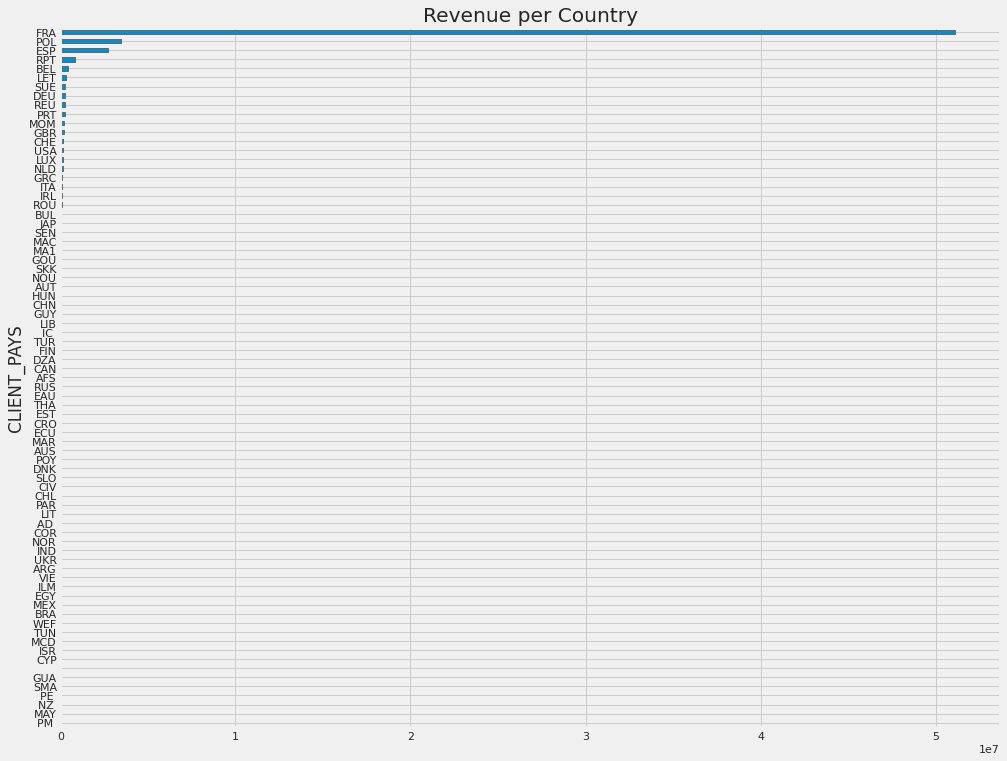

In [132]:
revenue_per_countries = df_cleaned.groupby(["CLIENT_PAYS"])["Total Revenue"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")b

Text(0.5, 1.0, 'Number of Invoices per Country')

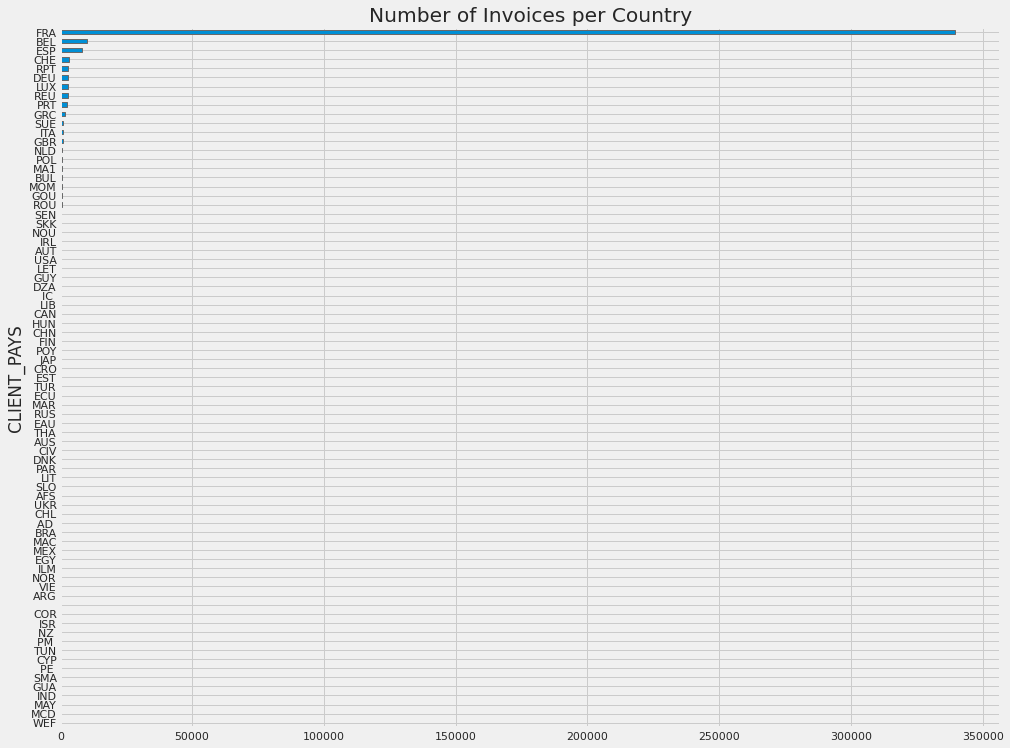

In [133]:
No_invoice_per_country = df_cleaned.groupby(["CLIENT_PAYS"])["Total Revenue"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Ibnvoices per Country")

This is very interesting since we can see that Pologne is the 2nd country in value even though it has less invoices than countries like Bel or Spain for example.

#### **Discount**


By analysing the ARTICLE_REF COLUMN, I discovered that it contains values related to the word REMISE (Discount). I supposed that the negative prices without cancelations (without considering negative quantity) could be explained by discounts. let's check this hypothesis


In [30]:
def sum_list(ls):
  s=0
  for l in ls:
    s+=l
  return s
  
neg_remise = df_cleaned[(df_cleaned["VENTE_MONTANT"]<0) & (~df_cleaned["VENTE_NATURE"].str.contains("AVOIR"))]["ARTICLE_REF"].value_counts()
print("Portion of transactions with negative prices explained by discounts : ",
      (sum_list([neg_remise[ref] for ref in neg_remise.keys() if "REMISE" in ref]))/neg_remise.sum())

Portion of transactions with negative prices explained by discounts :  0.9976106639839034


99.7% of transactions with negative prices are explained by discounts. the other purchases could be explained by samples given to customers to promote a product for example. I'm going to delete the latter since I can't validate this assumption.

In [31]:
# delete
doubtful_negative_prices = df_cleaned[(df_cleaned["VENTE_MONTANT"]<0) & (~df_cleaned["VENTE_NATURE"].str.contains("AVOIR")) & (~df_cleaned["ARTICLE_REF"].str.contains("REMISE"))].index
df_cleaned.drop(doubtful_negative_prices, inplace=True)

In [32]:
# Discounts by clients category
plot_pie(df_cleaned[(df_cleaned['VENTE_MONTANT']<0)&
                    (~df_cleaned["VENTE_NATURE"].str.contains("AVOIR"))]["CLIENT_CATEGORIE"].value_counts(),
         'CLIENT_CATEGORIE', 'DISCOUNTS BY CLIENT CATEGORIES', 50
         )

There are  8  unique  CLIENT_CATEGORIE  in this dataset.


On constate que 99% des remises ont été achetées par des clients de type PARTICULIER.  

Let's see the brands of discounted products.

In [33]:
# Discounts by brand
plot_pie(df_cleaned[(df_cleaned['VENTE_MONTANT']<0)&
                    (~df_cleaned["VENTE_NATURE"].str.contains("AVOIR"))]["ARTICLE_MARQUE"].value_counts(),
         'ARTICLE_MARQUE', 'DISCOUNTS BY ARTICLE_MARQUE', 50
         )

There are  1  unique  ARTICLE_MARQUE  in this dataset.


Interesing ! all discounted products are from the same brand : NC.  
This could explained by different events : 
* The company had stock surplus that they want to get rid of.
* The company uses a retention strategy for individuals with this brand. In that case, I'd say that the company chose this brand because it's the most solde.

## Segmentation

In this part, I'm going to apply the two approaches that I indicated in the EDA part :  
1. Segmentation based on CLIENT_CODE (with respect to the assumption).
2. Segmentation based on CLIENT_CATEGORIE.

For each approach, I'm going to use RFM and Clustring techniques.

### Segmentation based on CLIENT_CODE 

#### Segmentation variables

In [34]:
# the actual dataset
df_code = df_cleaned.copy()

Let's create a dummy variable for CLIENT_CODE values :

In [35]:
df_code = df_code.join(pd.get_dummies(df_code["CLIENT_CATEGORIE"])).drop(["CLIENT_CATEGORIE"], axis=1)
df_code.head(3)

,CLIENT_CODE,CLIENT_CPOSTAL,CLIENT_DPT,CLIENT_GEO,CLIENT_PAYS,ARTICLE_REF,ARTICLE_FAMILLE,ARTICLE_MARQUE,VENTE_DATE,VENTE_CANAL,VENTE_QTE,VENTE_MONTANT,VENTE_NUMEROPIECE,VENTE_NATURE,MARGE,QuantiteCanceled,Total Revenue,Total Price,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER
0,277,24250,24,FRANCE,FRA,REMISE_INTERNET,Non renseigné,NC,2015-12-28,VENTE EN LIGNE,1.0,-47.42,FACTURE702322,FACTURE,-47.42,0,-47.42,-47.42,0,0,0,0,0,0,0,0,0,0,0,1
1,277,24250,24,FRANCE,FRA,231K589,Electricité,NC,2015-12-28,VENTE EN LIGNE,2.0,7.00,FACTURE702322,FACTURE,4.50,0,9.00,14.00,0,0,0,0,0,0,0,0,0,0,0,1
2,277,24250,24,FRANCE,FRA,COLE6368W1,Moteur,NORMA,2015-12-28,VENTE EN LIGNE,4.0,9.68,FACTURE702322,FACTURE,5.40,0,21.60,38.72,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
#___________________________________________
# sum of prices and revenue / customer & invoice
temp = df_code.groupby(by=['CLIENT_CODE', 'VENTE_NUMEROPIECE'], as_index=False)[['Total Price', 'Total Revenue']].sum()
basket_price = temp.rename(columns = {'Total Price':'Basket Price', 'Total Revenue':'Basket Revenue'})
#_____________________
# invoice date
df_code['InvoiceDate_int'] = df_code['VENTE_DATE'].astype('int64')
temp = df_code.groupby(by=['CLIENT_CODE', 'VENTE_NUMEROPIECE'], as_index=False)['InvoiceDate_int'].mean()
df_code.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'VENTE_DATE'] = pd.to_datetime(temp['InvoiceDate_int'])

#___________________________________
# client categories 
temp = df_code.groupby(
    by=['CLIENT_CODE', 'VENTE_NUMEROPIECE'], 
    as_index=False)[['ADMINISTRATION', 'ASSOCIATION & CLUB', 'AUTRE',	'CIRCUIT',	'CONCESSIONNAIRE', 'DETAILLANT',
                     'ECOLE',	'EQUIPE COURSE', 'GARAGE', 'GRANDE DISTRIBUTION',
                     'INDUSTRIEL', 'PARTICULIER']].max()
basket_price[['ADMINISTRATION', 'ASSOCIATION & CLUB', 'AUTRE',	'CIRCUIT',	'CONCESSIONNAIRE', 'DETAILLANT',
                     'ECOLE',	'EQUIPE COURSE', 'GARAGE', 'GRANDE DISTRIBUTION',
                     'INDUSTRIEL', 'PARTICULIER']] =\
                     temp[['ADMINISTRATION', 'ASSOCIATION & CLUB', 'AUTRE',	'CIRCUIT',	'CONCESSIONNAIRE', 'DETAILLANT',
                     'ECOLE',	'EQUIPE COURSE', 'GARAGE', 'GRANDE DISTRIBUTION',
                     'INDUSTRIEL', 'PARTICULIER']]
# selection des entrées significatives:
#basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('Basket Price').head()

,CLIENT_CODE,VENTE_NUMEROPIECE,Basket Price,Basket Revenue,VENTE_DATE,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER
9836,0,FACTURE528318,-1881.180,-1881.180,2014-02-13,0,0,0,0,0,0,0,0,0,0,1,0
152023,38,FACTURE522941,-858.000,-390.000,2014-01-23,0,0,0,0,0,0,0,1,0,0,0,0
26513,0,FACTURE547809,-366.220,-144.220,2014-04-29,0,0,0,0,0,0,0,0,0,0,0,1
158730,591,FACTURE635169,-333.360,-333.360,2015-04-17,0,0,0,0,0,0,0,0,0,0,0,1
653,0,AVOIR54038,-272.004,-272.004,2015-03-25,0,0,0,0,0,0,0,0,0,0,0,1


dummy variable for VENTE_CANAL

In [37]:
# canal
df_code = df_code.join(pd.get_dummies(df_cleaned["VENTE_CANAL"])).drop(["VENTE_CANAL"], axis=1)
temp = df_code.groupby(
    by=['CLIENT_CODE', 'VENTE_NUMEROPIECE'], 
    as_index=False)[['VENTE A DISTANCE', 'VENTE EN LIGNE', 'BOUTIQUE',	'BOUTIQUE CIRCUIT']].max()
basket_price[['VENTE A DISTANCE', 'VENTE EN LIGNE', 'BOUTIQUE',	'BOUTIQUE CIRCUIT']] =\
                     temp[['VENTE A DISTANCE', 'VENTE EN LIGNE', 'BOUTIQUE',	'BOUTIQUE CIRCUIT']]

In [38]:
basket_price.head(3)

,CLIENT_CODE,VENTE_NUMEROPIECE,Basket Price,Basket Revenue,VENTE_DATE,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT
0,0,AVOIR45349,-12.54,-12.54,2014-01-03,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,AVOIR45350,-8.77,-8.77,2014-01-03,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,0,AVOIR45363,-9.70,-9.70,2014-01-03,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [39]:
#  visualize prices range
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
values = count_price

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig['data'][0].update({
                      'textinfo' : 'label+percent',
                      })
fig.update_layout(title="Répartition des montants des achats (factures)")
fig.show()

In [40]:
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_cust1 = basket_price.groupby(by=['CLIENT_CODE'])['Basket Price'].agg(['count','min','max','mean','sum'])
transactions_per_cust1 = transactions_per_cust1.rename(columns = {'min':'minPrice', 'max':'maxPrice', 
                                                                'mean':'meanPrice', 'sum':'sumPrice'})
transactions_per_cust2 = basket_price.groupby(by=['CLIENT_CODE'])['Basket Revenue'].agg(['count','min','max','mean','sum'])
transactions_per_cust2 = transactions_per_cust2.rename(columns = {'min':'minRevenue', 'max':'maxRevenue', 
                                                                'mean':'meanRevenue', 'sum':'sumRevenue'})
transactions_per_cust2.drop(["count"], axis=1, inplace=True)
transactions_per_cust3 = basket_price.groupby(by=["CLIENT_CODE"])[['ADMINISTRATION', 'ASSOCIATION & CLUB', 
                                                                   'AUTRE',	'CIRCUIT',	'CONCESSIONNAIRE', 'DETAILLANT',
                                                                   'ECOLE',	'EQUIPE COURSE', 'GARAGE', 'GRANDE DISTRIBUTION',
                                                                   'INDUSTRIEL', 'PARTICULIER']].sum()
transactions_per_cust4 = basket_price.groupby(by=["CLIENT_CODE"])[['VENTE A DISTANCE', 'VENTE EN LIGNE', 
                                                                   'BOUTIQUE',	'BOUTIQUE CIRCUIT']].sum()
merged = pd.merge(transactions_per_cust1, transactions_per_cust2, on="CLIENT_CODE")
merged2 = pd.merge(merged, transactions_per_cust3, on="CLIENT_CODE")
transactions_per_cust = pd.merge(merged2, transactions_per_cust4, on="CLIENT_CODE")

transactions_per_cust.reset_index(drop = False, inplace = True)
#basket_price.groupby(by=['CLIENT_CODE'])['categ_0'].sum()
transactions_per_cust.sort_values('CLIENT_CODE', ascending = True)


,CLIENT_CODE,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT
0,0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,-159356.2800,4.943896e+06,383.364229,5.818281e+07,4.0,2396.0,185.0,570.0,233.0,12831.0,452.0,2405.0,21536.0,238.0,3333.0,107586.0,55847.0,80521.0,7549.0,7852.0
1,38,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,-1687.4963,4.161238e+05,445.919668,2.807956e+06,0.0,332.0,38.0,74.0,0.0,87.0,22.0,132.0,1131.0,4.0,409.0,4068.0,2941.0,105.0,3107.0,144.0
2,56,5,10.0895,3.750385e+02,165.146800,8.257340e+02,3.2660,1.940398e+02,68.700800,3.435040e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
3,165,17,10.6240,1.135848e+03,301.308259,5.122240e+03,2.1440,3.628880e+02,100.237118,1.704031e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0
4,171,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,1027.4922,1.027492e+03,1027.492200,1.027492e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,1914,2,333.1660,4.871220e+02,410.144000,8.202880e+02,143.4760,2.548020e+02,199.139000,3.982780e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
1419,1915,4,46.0500,6.675000e+01,59.182500,2.367300e+02,11.3000,3.287770e+01,23.136650,9.254660e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0
1420,1916,5,29.8900,1.894600e+02,77.910000,3.895500e+02,3.4360,3.197000e+01,16.429720,8.214860e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0
1421,1918,5,66.3200,6.634650e+02,231.865800,1.159329e+03,24.5200,2.430351e+02,88.513820,4.425691e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0


In [41]:
last_date = basket_price['VENTE_DATE'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CLIENT_CODE'])['VENTE_DATE'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CLIENT_CODE'])['VENTE_DATE'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_cust.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['VENTE_DATE']
transactions_per_cust.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['VENTE_DATE']

transactions_per_cust

,CLIENT_CODE,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT,LastPurchase,FirstPurchase
0,0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,-159356.2800,4.943896e+06,383.364229,5.818281e+07,4.0,2396.0,185.0,570.0,233.0,12831.0,452.0,2405.0,21536.0,238.0,3333.0,107586.0,55847.0,80521.0,7549.0,7852.0,0,729
1,38,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,-1687.4963,4.161238e+05,445.919668,2.807956e+06,0.0,332.0,38.0,74.0,0.0,87.0,22.0,132.0,1131.0,4.0,409.0,4068.0,2941.0,105.0,3107.0,144.0,0,728
2,56,5,10.0895,3.750385e+02,165.146800,8.257340e+02,3.2660,1.940398e+02,68.700800,3.435040e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2,694
3,165,17,10.6240,1.135848e+03,301.308259,5.122240e+03,2.1440,3.628880e+02,100.237118,1.704031e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,13,587
4,171,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,1027.4922,1.027492e+03,1027.492200,1.027492e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,1914,2,333.1660,4.871220e+02,410.144000,8.202880e+02,143.4760,2.548020e+02,199.139000,3.982780e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,175,255
1419,1915,4,46.0500,6.675000e+01,59.182500,2.367300e+02,11.3000,3.287770e+01,23.136650,9.254660e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,43,463
1420,1916,5,29.8900,1.894600e+02,77.910000,3.895500e+02,3.4360,3.197000e+01,16.429720,8.214860e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,199,693
1421,1918,5,66.3200,6.634650e+02,231.865800,1.159329e+03,24.5200,2.430351e+02,88.513820,4.425691e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,268,689


In [42]:
n1 = transactions_per_cust[transactions_per_cust['count'] == 1].shape[0]
n2 = transactions_per_cust.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 486/1423  (34.15%)


#### Clustring

In [43]:
selected_customers = transactions_per_cust.copy(deep = True)
cluster_data = selected_customers.loc[:, selected_customers.columns != 'CLIENT_CODE']
matrix = cluster_data.to_numpy()

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [ 1.15002108e+02  1.26051763e+02  1.28543479e+04  2.63089268e+02
  1.37976747e+05 -6.17628550e+01  4.05056614e+03  1.07384568e+02
  4.33764480e+04  2.81096275e-03  1.92621223e+00  1.56711174e-01
  4.52565004e-01  1.65144062e-01  9.07800422e+00  3.33099086e-01
  1.82782853e+00  1.59880534e+01  1.70063247e-01  2.75333802e+00
  8.21482783e+01  4.24729445e+01  5.90541110e+01  7.80604357e+00
  5.66900914e+00  1.43141954e+02  3.11891778e+02]


In [45]:
# clustring approach 1
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

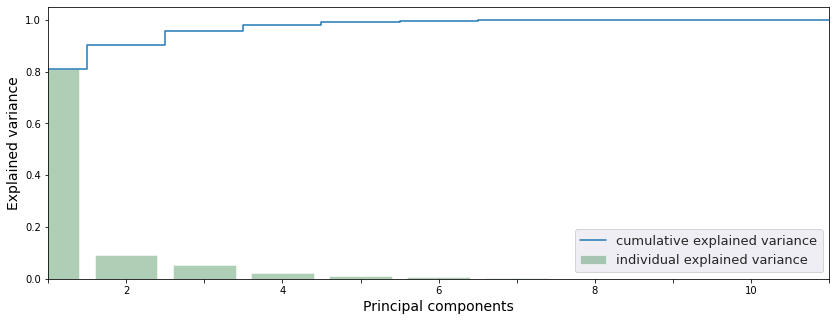

In [46]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
n_clusters = 8
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.407


In [48]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T


,2,0,4,3,6,5,7,1
nb. de clients,757,360,175,110,17,2,1,1


In [49]:
cluster_data['clusters']=clusters_clients
cluster_data

,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT,LastPurchase,FirstPurchase,clusters
0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,-159356.2800,4.943896e+06,383.364229,5.818281e+07,4.0,2396.0,185.0,570.0,233.0,12831.0,452.0,2405.0,21536.0,238.0,3333.0,107586.0,55847.0,80521.0,7549.0,7852.0,0,729,1
1,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,-1687.4963,4.161238e+05,445.919668,2.807956e+06,0.0,332.0,38.0,74.0,0.0,87.0,22.0,132.0,1131.0,4.0,409.0,4068.0,2941.0,105.0,3107.0,144.0,0,728,7
2,5,10.0895,3.750385e+02,165.146800,8.257340e+02,3.2660,1.940398e+02,68.700800,3.435040e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2,694,0
3,17,10.6240,1.135848e+03,301.308259,5.122240e+03,2.1440,3.628880e+02,100.237118,1.704031e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,13,587,0
4,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,1027.4922,1.027492e+03,1027.492200,1.027492e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,2,333.1660,4.871220e+02,410.144000,8.202880e+02,143.4760,2.548020e+02,199.139000,3.982780e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,175,255,2
1419,4,46.0500,6.675000e+01,59.182500,2.367300e+02,11.3000,3.287770e+01,23.136650,9.254660e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,43,463,0
1420,5,29.8900,1.894600e+02,77.910000,3.895500e+02,3.4360,3.197000e+01,16.429720,8.214860e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,199,693,0
1421,5,66.3200,6.634650e+02,231.865800,1.159329e+03,24.5200,2.430351e+02,88.513820,4.425691e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,268,689,0


In [61]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

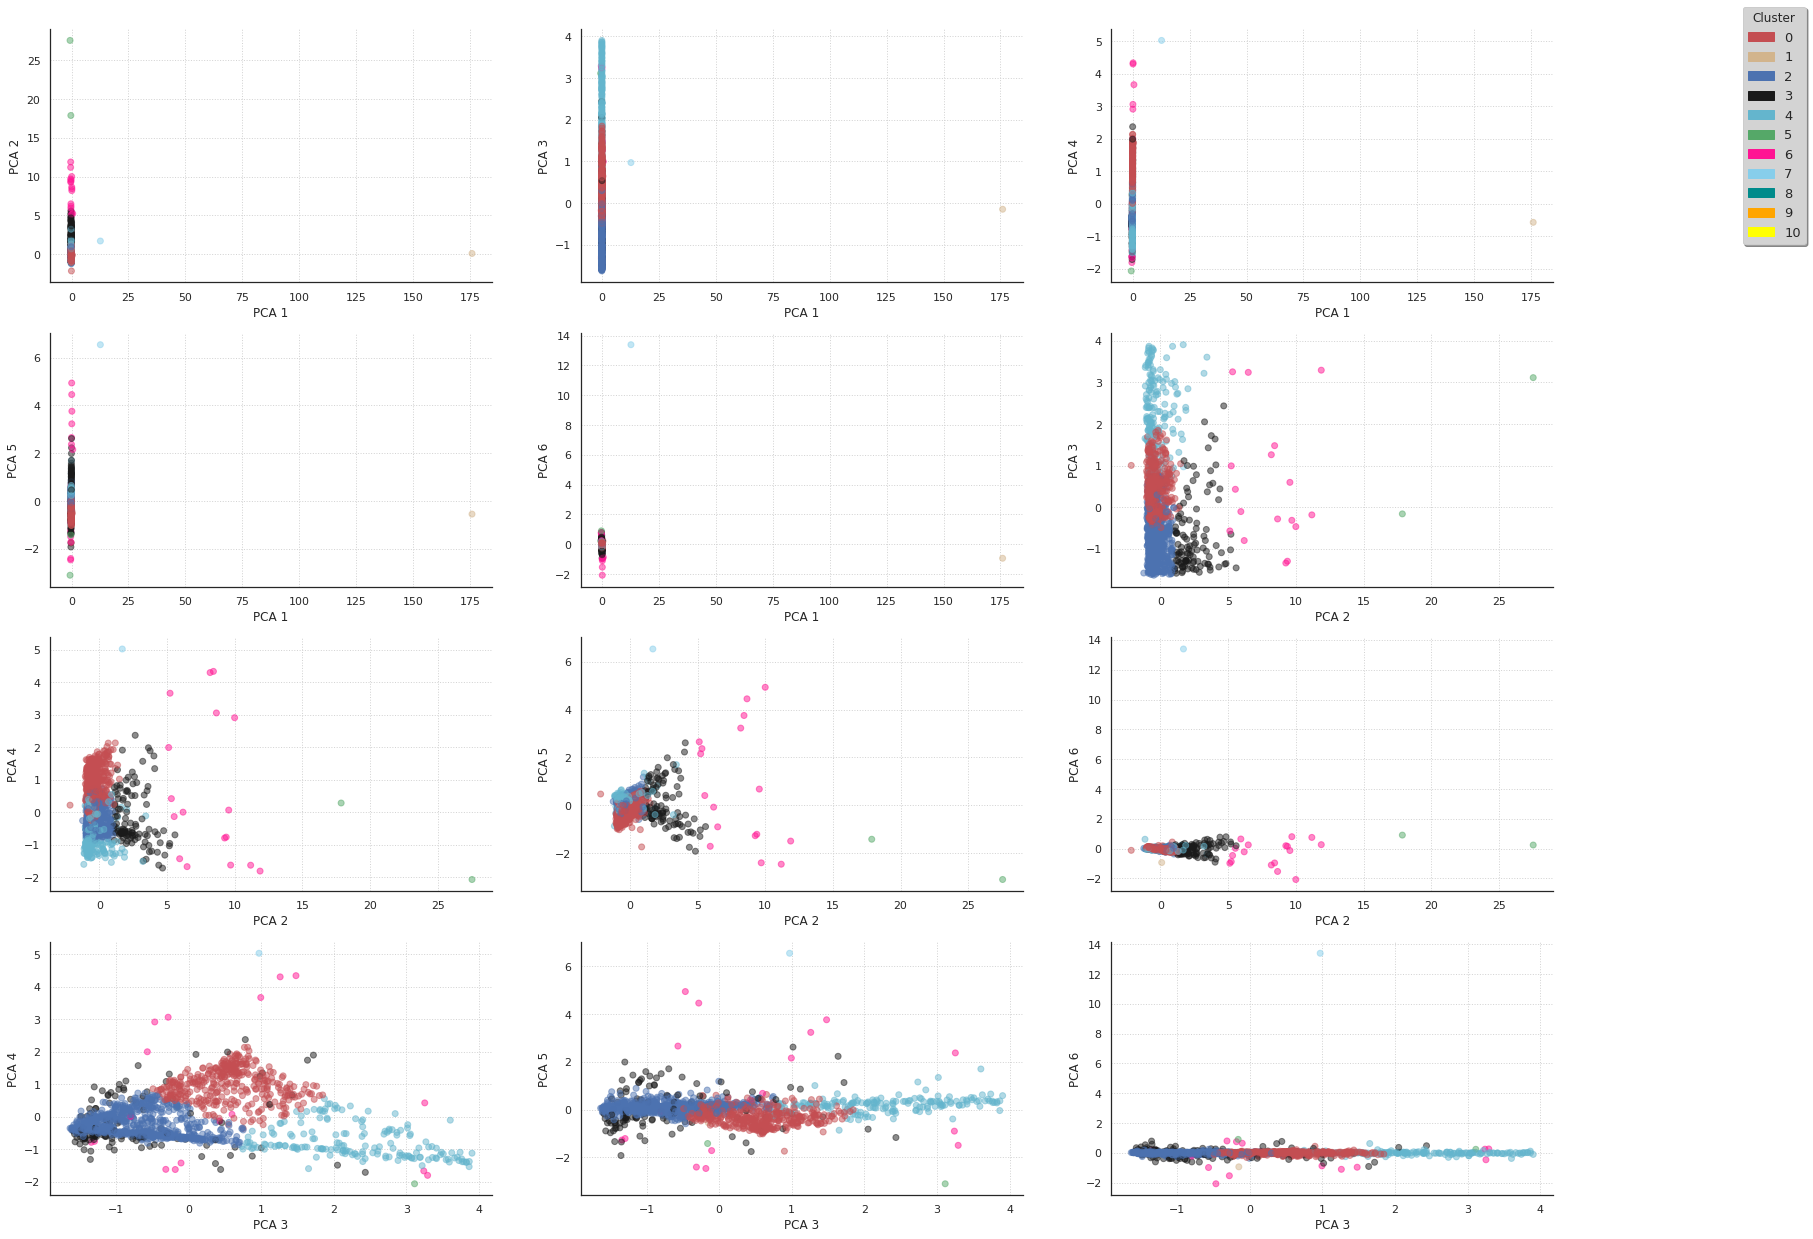

In [62]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (24,20))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

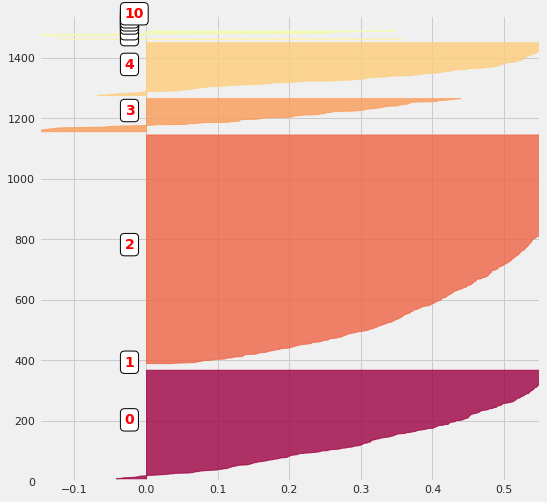

In [63]:
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [73]:
# clustring approach 2 :

x = list(range(2, 12))
y_std = []
for n_clusters in x:    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    y_std.append(silhouette_avg)
    #print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")
fig = go.Figure(data=go.Scatter(x=x, y=y_std))
fig.update_layout(title="Silhouette score", xaxis_title="Clusters", yaxis_title="Silhouette score")
fig.show()

In [80]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30, random_state=0)  # random state just to be able to provide cluster number during analysis
kmeans.fit(scaled_matrix)
clusters = kmeans.predict(scaled_matrix)

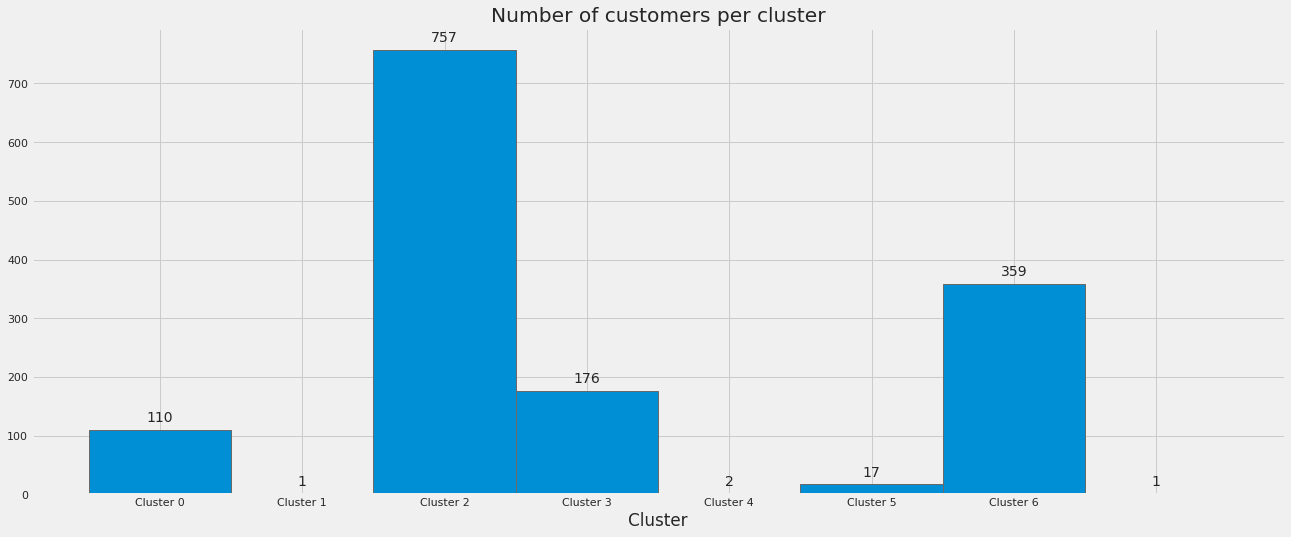

In [81]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=8)
plt.xlabel("Cluster")
plt.title("Number of customers per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(7)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      
        (x_value, y_value),         
        xytext=(0, space),          
        textcoords="offset points", 
        ha='center',                
        va=va)

In [83]:
cluster_data["CLIENT_CODE"] = transactions_per_cust["CLIENT_CODE"]
final_dataset_V1 = cluster_data
final_dataset_V1.head()

,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,ADMINISTRATION,ASSOCIATION & CLUB,AUTRE,CIRCUIT,CONCESSIONNAIRE,DETAILLANT,ECOLE,EQUIPE COURSE,GARAGE,GRANDE DISTRIBUTION,INDUSTRIEL,PARTICULIER,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT,LastPurchase,FirstPurchase,clusters,CLIENT_CODE
0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,-159356.2800,4.943896e+06,383.364229,5.818281e+07,4.0,2396.0,185.0,570.0,233.0,12831.0,452.0,2405.0,21536.0,238.0,3333.0,107586.0,55847.0,80521.0,7549.0,7852.0,0,729,1,0
1,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,-1687.4963,4.161238e+05,445.919668,2.807956e+06,0.0,332.0,38.0,74.0,0.0,87.0,22.0,132.0,1131.0,4.0,409.0,4068.0,2941.0,105.0,3107.0,144.0,0,728,7,38
2,5,10.0895,3.750385e+02,165.146800,8.257340e+02,3.2660,1.940398e+02,68.700800,3.435040e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2,694,0,56
3,17,10.6240,1.135848e+03,301.308259,5.122240e+03,2.1440,3.628880e+02,100.237118,1.704031e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,13,587,0,165
4,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,1027.4922,1.027492e+03,1027.492200,1.027492e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8,8,6,171


In [68]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
proj = tsne.fit_transform(scaled_matrix)

tsne_df = pd.DataFrame()
tsne_df["X"] = proj[:, 0]
tsne_df["Y"] = proj[:, 1]
tsne_df["Z"] = proj[:, 2]

fig = px.scatter_3d(tsne_df,"X","Y","Z",color=clusters.astype(str))
fig.show()

#### RFM

In [218]:
RFM_cust = transactions_per_cust[["CLIENT_CODE", "count", "minPrice", "maxPrice", 
                                  "meanPrice", "sumPrice", "LastPurchase", "FirstPurchase"]]
quantiles = RFM_cust.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_cust
segmented_rfm.head()

,CLIENT_CODE,count,minPrice,maxPrice,meanPrice,sumPrice,LastPurchase,FirstPurchase
0,0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,0,729
1,38,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,0,728
2,56,5,10.0895,3.750385e+02,165.146800,8.257340e+02,2,694
3,165,17,10.6240,1.135848e+03,301.308259,5.122240e+03,13,587
4,171,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,8,8


In [118]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [223]:
segmented_rfm['r_quartile'] = segmented_rfm['LastPurchase'].apply(RScore, args=('LastPurchase',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['count'].apply(FMScore, args=('count',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['meanPrice'].apply(FMScore, args=('meanPrice',quantiles,))
segmented_rfm.head()

,CLIENT_CODE,count,minPrice,maxPrice,meanPrice,sumPrice,LastPurchase,FirstPurchase,r_quartile,f_quartile,m_quartile
0,0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,0,729,1,1,1
1,38,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,0,728,1,1,1
2,56,5,10.0895,3.750385e+02,165.146800,8.257340e+02,2,694,1,1,2
3,165,17,10.6240,1.135848e+03,301.308259,5.122240e+03,13,587,1,1,2
4,171,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,8,8,1,4,1


In [224]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,CLIENT_CODE,count,minPrice,maxPrice,meanPrice,sumPrice,LastPurchase,FirstPurchase,r_quartile,f_quartile,m_quartile,RFMScore
0,0,151769,-1881.1800,1.607184e+07,1213.700569,1.842021e+08,0,729,1,1,1,111
1,38,6297,-858.0000,1.225372e+06,1634.064077,1.028970e+07,0,728,1,1,1,111
2,56,5,10.0895,3.750385e+02,165.146800,8.257340e+02,2,694,1,1,2,112
3,165,17,10.6240,1.135848e+03,301.308259,5.122240e+03,13,587,1,1,2,112
4,171,1,1903.9200,1.903920e+03,1903.920000,1.903920e+03,8,8,1,4,1,141


In [238]:
segmented_rfm["RFMScore"].value_counts().count()

64

#### Conclusion

### Segmentation based on CLIENT_CATEGORIE

#### Segmentation variables

In [156]:
# the actual dataset
df_cat = df_cleaned.copy()

In [157]:
#___________________________________________
# sum of prices and revenue / category & invoice
temp = df_cat.groupby(by=['CLIENT_CATEGORIE', 'VENTE_NUMEROPIECE'], as_index=False)[['Total Price', 'Total Revenue']].sum()
basket_price = temp.rename(columns = {'Total Price':'Basket Price', 'Total Revenue':'Basket Revenue'})
#_____________________
# invoice date
df_cat['InvoiceDate_int'] = df_cat['VENTE_DATE'].astype('int64')
temp = df_cat.groupby(by=['CLIENT_CATEGORIE', 'VENTE_NUMEROPIECE'], as_index=False)['InvoiceDate_int'].mean()
df_cat.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'VENTE_DATE'] = pd.to_datetime(temp['InvoiceDate_int'])

# canal
df_cat = df_cat.join(pd.get_dummies(df_cleaned["VENTE_CANAL"])).drop(["VENTE_CANAL"], axis=1)
temp = df_cat.groupby(
    by=['CLIENT_CATEGORIE', 'VENTE_NUMEROPIECE'], 
    as_index=False)[['VENTE A DISTANCE', 'VENTE EN LIGNE', 'BOUTIQUE',	'BOUTIQUE CIRCUIT']].max()
basket_price[['VENTE A DISTANCE', 'VENTE EN LIGNE', 'BOUTIQUE',	'BOUTIQUE CIRCUIT']] =\
                     temp[['VENTE A DISTANCE', 'VENTE EN LIGNE', 'BOUTIQUE',	'BOUTIQUE CIRCUIT']]

# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Revenue'] > 0]
basket_price.sort_values('Basket Price').head()

,CLIENT_CATEGORIE,VENTE_NUMEROPIECE,Basket Price,Basket Revenue,VENTE_DATE,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT
17194,ECOLE,FACTURE674306,0.0001,0.0001,2015-09-11,1,0,0,0
18531,EQUIPE COURSE,FACTURE596770,0.0100,0.0100,2014-11-19,1,0,0,0
117231,PARTICULIER,FACTURE630757,0.0100,0.0100,2015-04-01,0,1,0,0
21070,GARAGE,FACTURE527680,0.0115,0.0015,2014-02-11,1,0,0,0
551,ASSOCIATION & CLUB,FACTURE543240,0.0115,0.0015,2014-04-10,1,0,0,0


In [158]:
# nb de visites et stats sur le montant du panier / category
transactions_per_cat1 = basket_price.groupby(by=['CLIENT_CATEGORIE'])['Basket Price'].agg(['count','min','max','mean','sum'])
transactions_per_cat1 = transactions_per_cat1.rename(columns = {'min':'minPrice', 'max':'maxPrice', 
                                                                'mean':'meanPrice', 'sum':'sumPrice'})
transactions_per_cat2 = basket_price.groupby(by=['CLIENT_CATEGORIE'])['Basket Revenue'].agg(['count','min','max','mean','sum'])
transactions_per_cat2 = transactions_per_cat2.rename(columns = {'min':'minRevenue', 'max':'maxRevenue', 
                                                                'mean':'meanRevenue', 'sum':'sumRevenue'})
transactions_per_cat2.drop(["count"], axis=1, inplace=True)
transactions_per_cat3 = basket_price.groupby(by=["CLIENT_CATEGORIE"])[['VENTE A DISTANCE', 'VENTE EN LIGNE', 
                                                                   'BOUTIQUE',	'BOUTIQUE CIRCUIT']].sum()
merged = pd.merge(transactions_per_cat1, transactions_per_cat2, on="CLIENT_CATEGORIE")
transactions_per_cat = pd.merge(merged, transactions_per_cat3, on="CLIENT_CATEGORIE")

transactions_per_cat.reset_index(drop = False, inplace = True)
#basket_price.groupby(by=['CLIENT_CODE'])['categ_0'].sum()
transactions_per_cat.sort_values('CLIENT_CATEGORIE', ascending = True)

,CLIENT_CATEGORIE,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT
0,ADMINISTRATION,4,176.6800,4.972502e+03,1641.169500,6.564678e+03,78.8800,2.069030e+03,699.056775,2.796227e+03,4.0,0.0,0.0,0.0
1,ASSOCIATION & CLUB,2677,0.0115,1.017291e+07,5250.998570,1.405692e+07,0.0015,2.733853e+06,1632.967025,4.371453e+06,2009.0,154.0,497.0,17.0
2,AUTRE,196,2.9750,2.426112e+05,8572.538694,1.680218e+06,2.1000,9.020165e+04,2390.343461,4.685073e+05,128.0,49.0,18.0,1.0
3,CIRCUIT,614,2.7965,9.098719e+05,6727.341281,4.130588e+06,0.5400,1.981386e+05,1858.608236,1.141185e+06,361.0,11.0,119.0,123.0
4,CONCESSIONNAIRE,229,1.2640,2.030000e+05,1487.790754,3.407041e+05,0.3040,9.200000e+04,602.131680,1.378882e+05,214.0,1.0,14.0,0.0
5,DETAILLANT,12550,0.0115,2.228076e+06,2359.263566,2.960876e+07,0.0015,4.943880e+05,644.817370,8.092458e+06,12290.0,19.0,240.0,1.0
6,ECOLE,456,0.0001,2.183828e+06,35188.933439,1.604615e+07,0.0001,7.044504e+05,10192.861710,4.647945e+06,383.0,6.0,66.0,1.0
7,EQUIPE COURSE,2530,0.0100,4.715245e+05,2781.206885,7.036453e+06,0.0015,8.004420e+04,732.431494,1.853052e+06,2326.0,35.0,161.0,8.0
8,GARAGE,22287,0.0115,5.477493e+05,1403.701293,3.128429e+07,0.0015,1.484622e+05,388.631811,8.661437e+06,20304.0,308.0,1640.0,35.0
9,GRANDE DISTRIBUTION,232,1.4640,3.847203e+05,5710.735951,1.324891e+06,0.9142,1.447200e+05,1480.756167,3.435354e+05,229.0,0.0,3.0,0.0


In [159]:
last_date = basket_price['VENTE_DATE'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CLIENT_CATEGORIE'])['VENTE_DATE'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CLIENT_CATEGORIE'])['VENTE_DATE'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_cat.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['VENTE_DATE']
transactions_per_cat.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['VENTE_DATE']

transactions_per_cat

,CLIENT_CATEGORIE,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT,LastPurchase,FirstPurchase
0,ADMINISTRATION,4,176.6800,4.972502e+03,1641.169500,6.564678e+03,78.8800,2.069030e+03,699.056775,2.796227e+03,4.0,0.0,0.0,0.0,84,329
1,ASSOCIATION & CLUB,2677,0.0115,1.017291e+07,5250.998570,1.405692e+07,0.0015,2.733853e+06,1632.967025,4.371453e+06,2009.0,154.0,497.0,17.0,0,728
2,AUTRE,196,2.9750,2.426112e+05,8572.538694,1.680218e+06,2.1000,9.020165e+04,2390.343461,4.685073e+05,128.0,49.0,18.0,1.0,10,716
3,CIRCUIT,614,2.7965,9.098719e+05,6727.341281,4.130588e+06,0.5400,1.981386e+05,1858.608236,1.141185e+06,361.0,11.0,119.0,123.0,11,722
4,CONCESSIONNAIRE,229,1.2640,2.030000e+05,1487.790754,3.407041e+05,0.3040,9.200000e+04,602.131680,1.378882e+05,214.0,1.0,14.0,0.0,0,346
5,DETAILLANT,12550,0.0115,2.228076e+06,2359.263566,2.960876e+07,0.0015,4.943880e+05,644.817370,8.092458e+06,12290.0,19.0,240.0,1.0,0,728
6,ECOLE,456,0.0001,2.183828e+06,35188.933439,1.604615e+07,0.0001,7.044504e+05,10192.861710,4.647945e+06,383.0,6.0,66.0,1.0,16,727
7,EQUIPE COURSE,2530,0.0100,4.715245e+05,2781.206885,7.036453e+06,0.0015,8.004420e+04,732.431494,1.853052e+06,2326.0,35.0,161.0,8.0,1,727
8,GARAGE,22287,0.0115,5.477493e+05,1403.701293,3.128429e+07,0.0015,1.484622e+05,388.631811,8.661437e+06,20304.0,308.0,1640.0,35.0,0,728
9,GRANDE DISTRIBUTION,232,1.4640,3.847203e+05,5710.735951,1.324891e+06,0.9142,1.447200e+05,1480.756167,3.435354e+05,229.0,0.0,3.0,0.0,8,723


#### Hierarchical clustring

In [175]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

selected_cat = transactions_per_cat.copy(deep = True)
cluster_data = selected_cat.loc[:, selected_cat.columns != 'CLIENT_CATEGORIE']
matrix = cluster_data.to_numpy()

scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

# pca
from sklearn.decomposition import PCA
pca_h = PCA()
pca_h.fit(scaled_matrix)
pca_samples = pca_h.transform(scaled_matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [1.30861667e+04 1.54371333e+01 2.84470790e+06 7.41763284e+03
 1.63304715e+07 6.89560833e+00 8.19101251e+05 2.23632387e+03
 5.19001766e+06 4.88983333e+03 6.64225000e+03 9.05750000e+02
 6.48333333e+02 1.10000000e+01 6.60916667e+02 8.33333333e-01]


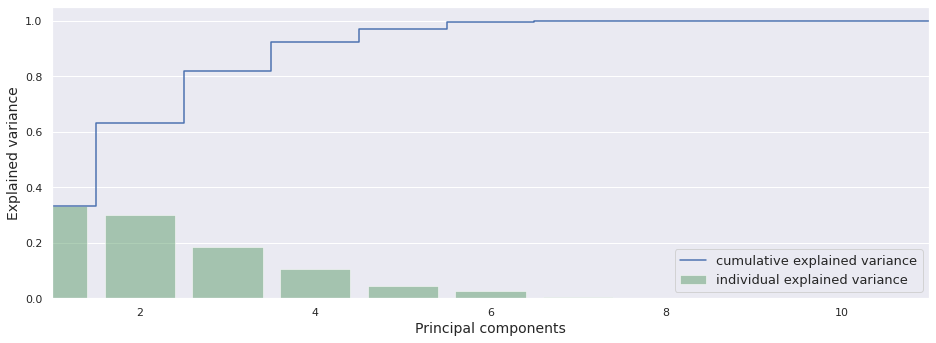

In [182]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[0]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[0]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [187]:
# pca
from sklearn.decomposition import PCA
pca_h = PCA(4)
pca_h.fit(scaled_matrix)
pca_samples = pca_h.transform(scaled_matrix)

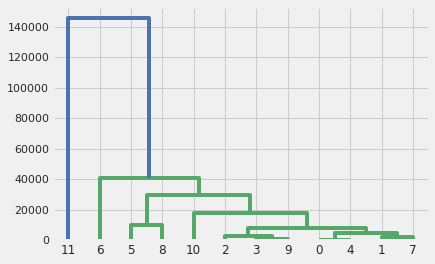

In [161]:
X = cluster_data.iloc[:, [0, 3]].values

dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

In [190]:
model = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
model.fit(pca_samples)
labels = model.labels_
transactions_per_cat["Clusters"] = labels
transactions_per_cat

,CLIENT_CATEGORIE,count,minPrice,maxPrice,meanPrice,sumPrice,minRevenue,maxRevenue,meanRevenue,sumRevenue,VENTE A DISTANCE,VENTE EN LIGNE,BOUTIQUE,BOUTIQUE CIRCUIT,LastPurchase,FirstPurchase,Clusters
0,ADMINISTRATION,4,176.6800,4.972502e+03,1641.169500,6.564678e+03,78.8800,2.069030e+03,699.056775,2.796227e+03,4.0,0.0,0.0,0.0,84,329,3
1,ASSOCIATION & CLUB,2677,0.0115,1.017291e+07,5250.998570,1.405692e+07,0.0015,2.733853e+06,1632.967025,4.371453e+06,2009.0,154.0,497.0,17.0,0,728,6
2,AUTRE,196,2.9750,2.426112e+05,8572.538694,1.680218e+06,2.1000,9.020165e+04,2390.343461,4.685073e+05,128.0,49.0,18.0,1.0,10,716,0
3,CIRCUIT,614,2.7965,9.098719e+05,6727.341281,4.130588e+06,0.5400,1.981386e+05,1858.608236,1.141185e+06,361.0,11.0,119.0,123.0,11,722,0
4,CONCESSIONNAIRE,229,1.2640,2.030000e+05,1487.790754,3.407041e+05,0.3040,9.200000e+04,602.131680,1.378882e+05,214.0,1.0,14.0,0.0,0,346,0
5,DETAILLANT,12550,0.0115,2.228076e+06,2359.263566,2.960876e+07,0.0015,4.943880e+05,644.817370,8.092458e+06,12290.0,19.0,240.0,1.0,0,728,2
6,ECOLE,456,0.0001,2.183828e+06,35188.933439,1.604615e+07,0.0001,7.044504e+05,10192.861710,4.647945e+06,383.0,6.0,66.0,1.0,16,727,4
7,EQUIPE COURSE,2530,0.0100,4.715245e+05,2781.206885,7.036453e+06,0.0015,8.004420e+04,732.431494,1.853052e+06,2326.0,35.0,161.0,8.0,1,727,0
8,GARAGE,22287,0.0115,5.477493e+05,1403.701293,3.128429e+07,0.0015,1.484622e+05,388.631811,8.661437e+06,20304.0,308.0,1640.0,35.0,0,728,2
9,GRANDE DISTRIBUTION,232,1.4640,3.847203e+05,5710.735951,1.324891e+06,0.9142,1.447200e+05,1480.756167,3.435354e+05,229.0,0.0,3.0,0.0,8,723,0


**Cluster 0 :** Cluster 0 represent customers catergories with good recency, have relatively low frequence and relatively good monetary. In addition, they tend to buy with the canal "A DISTANCE" more often. (Active customers that use "A DISTANCE" canal). 

**Cluster 1 :** This cluster represent only individuals. They buy a lot, low monetary and high recency. They use all kinds of canals. 

**Cluster 2 :** Buy a lot, average monetary and good recency. they use VENTE_A_DISTANCE and BOUTIQUE more often. (top to active customers)

**Cluster 3 :** very low frequence, low monetary and low recency (lost customers).

**Cluster 4 :** 


#### **RFM**

In [126]:
RFM_cat = transactions_per_cat[["CLIENT_CATEGORIE", "count", "sumPrice", "meanPrice", "LastPurchase"]]
quantiles = RFM_cat.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_cat
segmented_rfm.head()

,CLIENT_CATEGORIE,count,sumPrice,meanPrice,LastPurchase
0,ADMINISTRATION,4,6.564678e+03,1641.169500,84
1,ASSOCIATION & CLUB,2741,1.405758e+07,5128.630645,0
2,AUTRE,223,1.680297e+06,7534.966317,8
3,CIRCUIT,644,4.133049e+06,6417.777897,11
4,CONCESSIONNAIRE,235,3.412652e+05,1452.192503,0


In [167]:
segmented_rfm['r_quartile'] = segmented_rfm['LastPurchase'].apply(RScore, args=('LastPurchase',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['count'].apply(FMScore, args=('count',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['meanPrice'].apply(FMScore, args=('meanPrice',quantiles,))
segmented_rfm

,CLIENT_CATEGORIE,count,sumPrice,meanPrice,LastPurchase,r_quartile,f_quartile,m_quartile,RFMScore
0,ADMINISTRATION,4,6.564678e+03,1641.169500,84,4,4,3,444
1,ASSOCIATION & CLUB,2741,1.405758e+07,5128.630645,0,1,2,2,122
2,AUTRE,223,1.680297e+06,7534.966317,8,3,4,1,343
3,CIRCUIT,644,4.133049e+06,6417.777897,11,4,3,2,433
4,CONCESSIONNAIRE,235,3.412652e+05,1452.192503,0,1,4,4,144
5,DETAILLANT,12918,2.964417e+07,2294.795614,0,1,1,3,111
6,ECOLE,474,1.604848e+07,33857.547450,16,4,3,1,432
7,EQUIPE COURSE,2601,7.039367e+06,2706.408060,1,2,2,3,223
8,GARAGE,22751,3.138578e+07,1379.534184,0,1,1,4,111
9,GRANDE DISTRIBUTION,242,1.325006e+06,5475.232387,8,3,3,2,334


In [168]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm

,CLIENT_CATEGORIE,count,sumPrice,meanPrice,LastPurchase,r_quartile,f_quartile,m_quartile,RFMScore
0,ADMINISTRATION,4,6.564678e+03,1641.169500,84,4,4,3,443
1,ASSOCIATION & CLUB,2741,1.405758e+07,5128.630645,0,1,2,2,122
2,AUTRE,223,1.680297e+06,7534.966317,8,3,4,1,341
3,CIRCUIT,644,4.133049e+06,6417.777897,11,4,3,2,432
4,CONCESSIONNAIRE,235,3.412652e+05,1452.192503,0,1,4,4,144
5,DETAILLANT,12918,2.964417e+07,2294.795614,0,1,1,3,113
6,ECOLE,474,1.604848e+07,33857.547450,16,4,3,1,431
7,EQUIPE COURSE,2601,7.039367e+06,2706.408060,1,2,2,3,223
8,GARAGE,22751,3.138578e+07,1379.534184,0,1,1,4,114
9,GRANDE DISTRIBUTION,242,1.325006e+06,5475.232387,8,3,3,2,332


Based on recency, frequency and monetary, we were able to segment the customer categories into the following segments: 

1. **Top Customers** (current, frequent, large revenues) : ASSOCIATION & CLUB, DETAILLANT
2. **Emerging customers** (potential for cross- and upselling) : EQUIPE COURSE, 
3. **Unsteady customer** (potential for cross- and upselling depending on the offer) : PARTICULIER, GARAGE, CONCESSIONNAIRE
4. **Customers at risk** (non-current but partly frequent and high revenues) : ECOLE, INDUSTRIEL, Autre, GRANDE DISTRIBUTION
5. **Lost customers** (non-current, rare, low revenues) : ADMINISTRATION, CIRCUIT  

We can see some insights by comparing these results with those of the hierarchical model: 

* ADMINISTRATION and CIRCUIT are considered lost customers. Although, the hierarchical model considered ADMINISTRATION as belonging to unitary cluster (5) and CIRCUIT to the cluster 0. This is due to the additional variables about min, max revenue and canal variables. 
* 
